In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import seaborn as sns

In [3]:
mnist_x = pd.read_csv(r"mnist_X.csv",header=None)
mnist_y = pd.read_csv(r"mnist_label.csv",header=None)
print("Shape of X :",mnist_x.shape)
print("Shape of Y :",mnist_y.shape)

Shape of X : (5000, 784)
Shape of Y : (5000, 1)


# General steps for performing a linear discriminant analysis

1. Compute the d-dimensional mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors (e1,e2,...,ed) and corresponding eigenvalues (λ1,λ2,...,λd) for the scatter matrices.
4. Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d×k dimensional matrix WW (where every column represents an eigenvector).
5. Use this d×k eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication: YY=X×W (where XX is a n×d-dimensional matrix representing the n samples, and yy are the transformed n×k-dimensional samples in the new subspace).

reference: https://sebastianraschka.com/Articles/2014_python_lda.html

In [4]:
#calculate overall mean of data
overall_mean = np.mean(mnist_x,axis=0).values.reshape(784,1)
#calculate mean vector of the each class
mean_vec = []
for i in mnist_y[0].unique():
    mean_vec.append(np.array((mnist_x[mnist_y[0]==i].mean()) ))

In [5]:
# compute within-class scatter matrix
SW = np.zeros((784,784))
for i in range(1,6):
    per_class_sc_mat = np.zeros((784,784))
    data_count_per_class = (mnist_x[mnist_y[0]==i].shape[0])
    for j in range(data_count_per_class):
        row = mnist_x.loc[1].values.reshape(784,1)
        mv  = mean_vec[i-1].reshape(784,1)
        per_class_sc_mat += (row-mv).dot((row-mv).T)
    SW += per_class_sc_mat
print('within-class Scatter Matrix Shape:\n', SW.shape)    
print('within-class Scatter Matrix:\n', SW)

within-class Scatter Matrix Shape:
 (784, 784)
within-class Scatter Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
#compute in-between-class scatter matrix
SB = np.zeros((784,784))
for i in range(1,6):#5 number of classes
    n= (mnist_x[mnist_y[0]==i].shape[0])
    mv  = mean_vec[i-1].reshape(784,1)
    overall_mean = overall_mean
    SB += n * (mv - overall_mean).dot((mv - overall_mean).T)
print('between-class Scatter Matrix:\n', SB)

between-class Scatter Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d×k dimensional matrix W(where every column represents an eigenvector).

In [8]:
#compute eigen value and eigen vectors 
e_vals, e_vecs = np.linalg.eig(np.linalg.pinv(SW).dot(SB))
# Make a list of (eigenvalue, eigenvector) tuples
e_pairs = [(np.abs(e_vals[i]), e_vecs[:,i]) for i in range(len(e_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
e_pairs = sorted(e_pairs, key=lambda k: k[0], reverse=True)

# form a d×k dimensional matrix WW (where every column represents an eigenvector).
W = np.hstack((e_pairs[0][1].reshape(784,1), e_pairs[1][1].reshape(784,1)))
print('Matrix W Shape:\n', W.real.shape)
print('Matrix W :\n', W.real)

Matrix W Shape:
 (784, 2)
Matrix W :
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [10]:
#Use this d×k eigenvector matrix to transform the samples onto the new subspace. Y=mnist_x×W
Y = np.array(mnist_x).dot(W)
# prepare dataframe for visualization 
mnst_y = mnist_y.copy()
Y = np.vstack((Y.T, mnst_y.T))
Y = Y.T
Y = pd.DataFrame(Y, columns=['LDA1','LDA2', 'label'])
Y.label = Y.label.astype(np.int)
Y.head()

C:\Users\Rashid Ali\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:703: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)


,LDA1,LDA2,label
0,(1.8155759637134052+0j),(0.9297209743572187+1.37180751026883j),1
1,(1.5361521378681153+0j),(1.6263426638869416+1.5305067621660615j),1
2,(2.092929906152071+0j),(1.8281030756565362+2.412513055004709j),1
3,(2.215985129991338+0j),(1.8360503130334584+1.8041446631659903j),1
4,(1.2517641554717196+0j),(1.1293500620713421+2.184114432610436j),1


C:\Users\Rashid Ali\Anaconda3\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


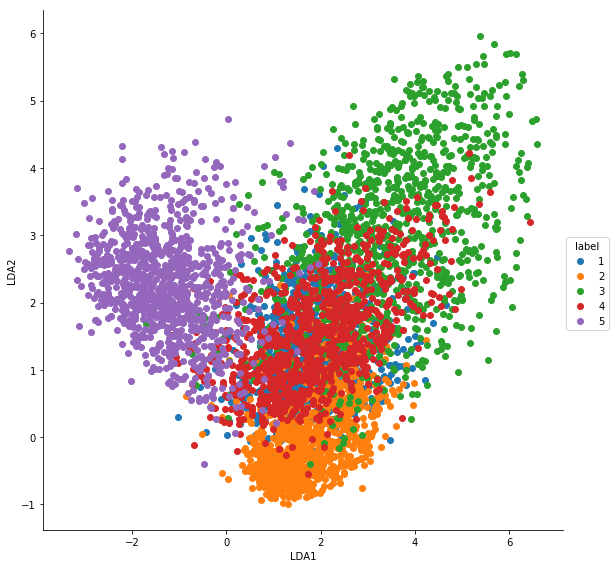

In [11]:
# visualize the first 2 LDA components in 2D
sns_plot = sns.FacetGrid(Y, hue='label', size=8).map(plt.scatter,'LDA1','LDA2').add_legend()
sns_plot.savefig("LDA.png")